### Определение перспективного тарифа для телеком компании

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

##### Тариф «Смарт»
Ежемесячная плата: 550 рублей
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета:
минута разговора: 3 рубля
сообщение: 3 рубля
1 Гб интернет-трафика: 200 рублей
##### Тариф «Ультра»

Ежемесячная плата: 1950 рублей
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета:
минута разговора: 1 рубль
сообщение: 1 рубль
1 Гб интернет-трафика: 150 рублей

### Шаг 1. 
Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
from scipy import stats as st

In [2]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

for data in [calls, internet, messages, tariffs, users]: print(data.info(), data.head(), end='\n\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None        id   call_date  duration  user_id
0  1000_0  2018-07-25      0.00     1000
1  1000_1  2018-08-17      0.00     1000
2  1000_2  2018-06-11      2.85     1000
3  1000_3  2018-09-21     13.80     1000
4  1000_4  2018-12-15      5.18     1000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
None    Unnamed: 0      id  mb_used session_date  user_id
0       

### Шаг 2. 
Подготовьте данные, приведите данные к нужным типам;
Найдите и исправьте ошибки в данных.
Поясните, какие ошибки вы нашли и как их исправили. 
Обратите внимание, что длительность многих звонков — 0.0 минут. Это могут быть пропущенные звонки. 
Обрабатывать ли эти нулевые значения, решать вам — оцените, как их отсутствие повлияет на результаты анализа.

In [3]:
# отформатируем формат даты для добавления столбца 'month'
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format="%Y-%m-%d")
users['churn_date'] = pd.to_datetime(users['churn_date'], format="%Y-%m-%d")

In [4]:
# добавляем столбец
calls['month'] = pd.to_datetime(calls['call_date']).dt.month
messages['month'] = pd.to_datetime(messages['message_date']).dt.month
internet['month'] = pd.to_datetime(internet['session_date']).dt.month

In [5]:
# округляем в большую сторону продолжительность звонков и трафика
calls['duration'] = calls['duration'].apply(np.ceil).astype('int')
internet['mb_used'] = internet['mb_used'].apply(np.ceil).astype('int')

# избавляемся от пропущенных звонков - на выборку 0 повлиять не может независимо от тарифа
calls['duration'] = calls['duration'].replace(0, np.NaN)
calls = calls.dropna()
calls.describe()

,duration,user_id,month
count,162994.000000,162994.000000,162994.000000
mean,8.897880,1254.149877,8.572960
std,5.353761,144.751050,2.787315
min,1.000000,1000.000000,1.000000
25%,5.000000,1126.000000,7.000000
50%,8.000000,1261.000000,9.000000
75%,12.000000,1379.000000,11.000000
max,38.000000,1499.000000,12.000000


In [6]:
display(internet['mb_used'].describe())
internet['gb_used'] = (internet['mb_used'] / 1024)

count    149396.000000
mean        370.622098
std         278.387019
min           0.000000
25%         139.000000
50%         349.000000
75%         560.000000
max        1725.000000
Name: mb_used, dtype: float64

In [7]:
# изменим тип данных - приведём его к int
messages['user_id'] = messages['user_id'].astype('int')
calls['id'] = calls['id'].astype('int')

tariffs = tariffs.rename(columns={'tariff_name':'tariff'})

### Найдем для каждого пользователя:

#### количество сделанных звонков и израсходованных минут разговора по месяцам

In [8]:
user_calls = calls.groupby(['user_id', 'month'])\
.agg({'duration':'sum', 'id':'count'})\
.reset_index()\
.rename(columns={'id':'calls_id'})\

In [9]:
user_calls.head()

,user_id,month,duration,calls_id
0,1000,5,159.0,17
1,1000,6,172.0,28
2,1000,7,340.0,41
3,1000,8,408.0,42
4,1000,9,466.0,46


#### количество отправленных сообщений по месяцам

In [10]:
user_messages = messages.groupby(['user_id', 'month'])\
.agg({'id':'count'})\
.reset_index()\
.rename(columns={'id':'sms_id'})

In [11]:
user_messages.head()

,user_id,month,sms_id
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


#### объем израсходованного интернет-трафика по месяцам

In [12]:
user_internet = internet.groupby(['user_id', 'month'])\
.agg({'mb_used':'sum'})\
.reset_index()\

In [13]:
user_internet.head()

,user_id,month,mb_used
0,1000,5,2256
1,1000,6,23257
2,1000,7,14016
3,1000,8,14070
4,1000,9,14581


In [14]:
df = user_calls.merge(user_messages, on=['user_id','month'], how='outer')
df = df.merge(user_internet, on=['user_id','month'], how = 'outer')
df.head()

,user_id,month,duration,calls_id,sms_id,mb_used
0,1000,5,159.0,17.0,22.0,2256.0
1,1000,6,172.0,28.0,60.0,23257.0
2,1000,7,340.0,41.0,75.0,14016.0
3,1000,8,408.0,42.0,81.0,14070.0
4,1000,9,466.0,46.0,57.0,14581.0


In [15]:
df.head()

,user_id,month,duration,calls_id,sms_id,mb_used
0,1000,5,159.0,17.0,22.0,2256.0
1,1000,6,172.0,28.0,60.0,23257.0
2,1000,7,340.0,41.0,75.0,14016.0
3,1000,8,408.0,42.0,81.0,14070.0
4,1000,9,466.0,46.0,57.0,14581.0


In [16]:
df = df.merge(users, on='user_id', how='left')
df.head()

,user_id,month,duration,calls_id,sms_id,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,5,159.0,17.0,22.0,2256.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,6,172.0,28.0,60.0,23257.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,7,340.0,41.0,75.0,14016.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,8,408.0,42.0,81.0,14070.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,9,466.0,46.0,57.0,14581.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra


In [17]:
df = df.merge(tariffs, on='tariff', how='left')
df.head()

,user_id,month,duration,calls_id,sms_id,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,159.0,17.0,22.0,2256.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1000,6,172.0,28.0,60.0,23257.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
2,1000,7,340.0,41.0,75.0,14016.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
3,1000,8,408.0,42.0,81.0,14070.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
4,1000,9,466.0,46.0,57.0,14581.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1


In [18]:
df.isna().sum()

user_id                     0
month                       0
duration                   46
calls_id                   46
sms_id                    497
mb_used                    11
age                         0
churn_date               3027
city                        0
first_name                  0
last_name                   0
reg_date                    0
tariff                      0
messages_included           0
mb_per_month_included       0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
dtype: int64

In [19]:
# найдем и заменим все значения NaN на 0

df['sms_id'] = df['sms_id'].fillna(0)
df['mb_used'] = df['mb_used'].fillna(0)
df['duration'] = df['duration'].fillna(0)
df['calls_id'] = df['calls_id'].fillna(0)

In [20]:
df.isna().sum()

user_id                     0
month                       0
duration                    0
calls_id                    0
sms_id                      0
mb_used                     0
age                         0
churn_date               3027
city                        0
first_name                  0
last_name                   0
reg_date                    0
tariff                      0
messages_included           0
mb_per_month_included       0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
dtype: int64

#### помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

In [21]:
# напишем функцию для подсчета стоимости за услуги сверх тарифного пакета   

def above_the_tariff(row):
    sms = (row['sms_id'] - row['messages_included']) * row['rub_per_message']
    mins = (row['calls_id'] - row['minutes_included']) * row['rub_per_minute']
    mbs = np.ceil((row['mb_used'] - row['mb_per_month_included']) * row['rub_per_gb'] / 1024)
    total = 0
    for i in [sms, mins, mbs]:
        if i > 0:
            total += i
    return total


In [22]:
df['above_the_tariff'] = df.apply(lambda x: above_the_tariff(x), axis=1)

In [23]:
df['total_paid'] = df['rub_monthly_fee'] + df['above_the_tariff']

In [24]:
df.sort_values(by='total_paid').tail()

,user_id,month,duration,calls_id,sms_id,mb_used,age,churn_date,city,first_name,...,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,above_the_tariff,total_paid
615,1098,12,588.0,63.0,14.0,36568.0,39,NaT,Челябинск,Элеонора,...,smart,50,15360,500,550,200,3,3,4143.0,4693.0
782,1124,10,1225.0,130.0,121.0,49789.0,54,NaT,Махачкала,Альбин,...,ultra,1000,30720,3000,1950,150,1,1,2794.0,4744.0
3099,1486,11,764.0,84.0,96.0,36319.0,35,NaT,Нижний Новгород,Матвей,...,smart,50,15360,500,550,200,3,3,4232.0,4782.0
260,1042,12,728.0,94.0,75.0,37219.0,42,NaT,Хабаровск,Константин,...,smart,50,15360,500,550,200,3,3,4345.0,4895.0
3100,1486,12,1007.0,115.0,83.0,38610.0,35,NaT,Нижний Новгород,Матвей,...,smart,50,15360,500,550,200,3,3,4641.0,5191.0


### Шаг 3. 

Проанализируйте данные

Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

In [25]:
df.dropna(subset=['duration'], inplace=True)
desc_stat = df.pivot_table(index=['tariff'], values=['duration', 'mb_used', 'sms_id'], 
                    aggfunc={'duration': [np.mean, np.var, np.std], 
                             'mb_used': [np.mean, np.var, np.std], 
                             'sms_id': [np.mean, np.var, np.std]})
desc_stat

duration                                  mb_used                \
              mean         std            var          mean           std   
tariff                                                                      
smart   417.934948  190.313730   36219.315784  16229.188425   5877.576978   
ultra   526.623350  317.606098  100873.633397  19486.901523  10096.317202   

                         sms_id                          
                 var       mean        std          var  
tariff                                                   
smart   3.454591e+07  33.384029  28.227876   796.812958  
ultra   1.019356e+08  49.363452  47.804457  2285.266143

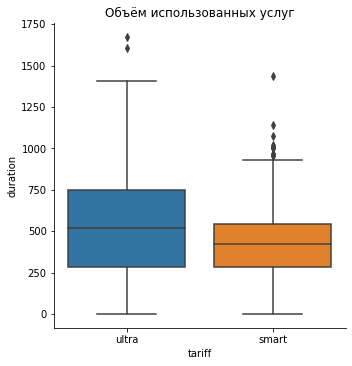

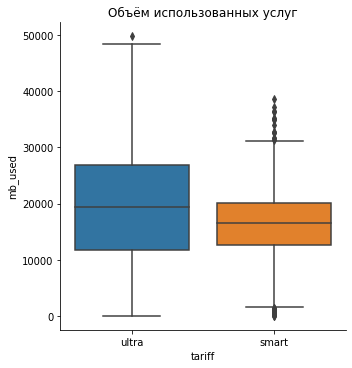

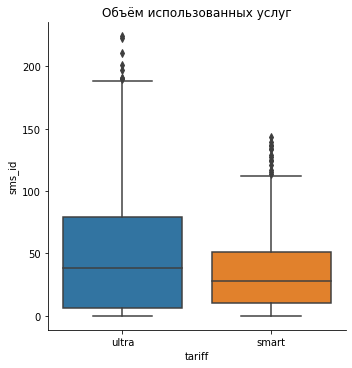

In [26]:
for column in ['duration', 'mb_used', 'sms_id']:    
    sns.catplot(x="tariff", y=column, kind="box", data=df, orient='v')
    plt.title('Объём использованных услуг')

Выбросов в рамках тарифа «Ультра» существенно больше.
По сравнению с тарифом «Смарт» услуги на тарифе «Ультра» имеет большую дисперсию и медианы по вышеперечисленным признакам также смещены в большую сторону. 

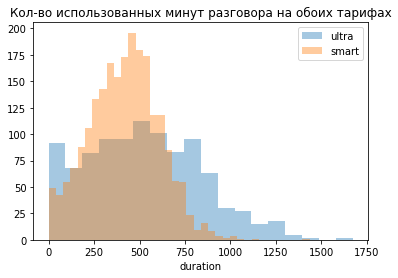

In [27]:
for tariff in ['ultra', 'smart']:
    sns.distplot(df.query('tariff == @tariff')['duration'], kde=False, label=tariff)
_ = plt.legend(['ultra', 'smart'])
plt.title('Кол-во использованных минут разговора на обоих тарифах');

Text(0.5, 1.0, 'Кол-во использованных мегабайтов на обоих тарифах')

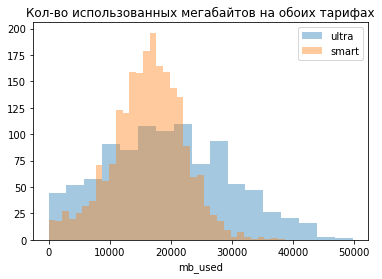

In [28]:
for tariff in ['ultra', 'smart']:
    sns.distplot(df.query('tariff == @tariff')['mb_used'], kde=False)
_ = plt.legend(['ultra', 'smart'])
plt.title('Кол-во использованных мегабайтов на обоих тарифах')

Text(0.5, 1.0, 'Кол-во использованных смс на обоих тарифах')

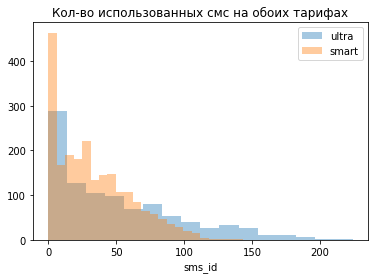

In [29]:
for tariff in ['ultra', 'smart']:
    sns.distplot(df.query('tariff == @tariff')['sms_id'], kde=False, label=tariff)
_ = plt.legend(['ultra', 'smart'])
plt.title('Кол-во использованных смс на обоих тарифах')

Распределения - тариф "Ультра"

Кол-во минут - нормальное

Кол-во мегабайт - нормальное

Кол-во сообщений - распределение Пуассона

Распределения - тариф "Смарт"

Кол-во минут - нормальное

Кол-во сообщений - распределение Пуассона

Кол-во мегабайт - нормальное


Поведение пользователей тарифа "Ультра" более разнообразное.

### Шаг 4. 

Проверьте гипотезы 

*средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;  

Пороговое значение alpha задайте самостоятельно. 
Поясните: как вы формулировали нулевую и альтернативную гипотезы; какой критерий использовали для проверки гипотез и почему.
Проверим гипотезы

Гипотеза 1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.
Нулевой гипотезой H0 будет гипотеза о том, что средние наших выборок равны. 
Альтернативной гипотезой H1 будет наша гипотеза "Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается".

Дисперсии наших выборок отличаются - использую метод scipy.stats.ttest_ind (array1, array2, equal_var = False)

Пороговое значение alpha задам равным 0.01.
Выбросы влияют на распределение t-критерия - в первую очередь избавимся от них.

In [30]:
Q1 = df['total_paid'].quantile(0.25)
Q3 = df['total_paid'].quantile(0.75)
IQR = Q3 - Q1
del_1 = df[(df['total_paid'] < Q1-1.5*IQR ) | (df['total_paid'] > Q3+1.5*IQR)]['total_paid']
del_1
data = df[~df['total_paid'].isin(del_1)].reset_index(drop = True)
df

,user_id,month,duration,calls_id,sms_id,mb_used,age,churn_date,city,first_name,...,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,above_the_tariff,total_paid
0,1000,5,159.0,17.0,22.0,2256.0,52,NaT,Краснодар,Рафаил,...,ultra,1000,30720,3000,1950,150,1,1,0.0,1950.0
1,1000,6,172.0,28.0,60.0,23257.0,52,NaT,Краснодар,Рафаил,...,ultra,1000,30720,3000,1950,150,1,1,0.0,1950.0
2,1000,7,340.0,41.0,75.0,14016.0,52,NaT,Краснодар,Рафаил,...,ultra,1000,30720,3000,1950,150,1,1,0.0,1950.0
3,1000,8,408.0,42.0,81.0,14070.0,52,NaT,Краснодар,Рафаил,...,ultra,1000,30720,3000,1950,150,1,1,0.0,1950.0
4,1000,9,466.0,46.0,57.0,14581.0,52,NaT,Краснодар,Рафаил,...,ultra,1000,30720,3000,1950,150,1,1,0.0,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,10,0.0,0.0,21.0,19588.0,35,NaT,Санкт-Петербург,Павел,...,smart,50,15360,500,550,200,3,3,826.0,1376.0
3210,1489,11,0.0,0.0,20.0,17516.0,35,NaT,Санкт-Петербург,Павел,...,smart,50,15360,500,550,200,3,3,422.0,972.0
3211,1489,12,0.0,0.0,35.0,17341.0,35,NaT,Санкт-Петербург,Павел,...,smart,50,15360,500,550,200,3,3,387.0,937.0
3212,1240,2,0.0,0.0,0.0,961.0,30,NaT,Воронеж,Зинаида,...,ultra,1000,30720,3000,1950,150,1,1,0.0,1950.0


In [31]:
ultra = df.query('tariff == "ultra"')['total_paid']
smart = df.query('tariff == "smart"')['total_paid']

alpha = .01

results = st.ttest_ind(ultra, smart, equal_var=False)

print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.0
Отвергаем нулевую гипотезу


In [32]:
df.pivot_table(index='tariff', values='total_paid', aggfunc='mean') 

,total_paid
tariff,
smart,1108.824136
ultra,2060.598985


Спасибо! Поправил.

Можно подтвердить, что доходы "Мегалайна" с пользователя по тарифу "Ультра" действительно отличаются по сравнению с доходами от тарифа "Смарт".

Гипотеза 2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Нулевой гипотезой H0 будет гипотеза о том, что средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов.

Альтернативной гипотезой H1 будет наша гипотеза "Средняя выручка пользователей из Москвы отличается от средней выручки пользователей из других регионов".

Дисперсии наших выборок отличаются - использую метод scipy.stats.ttest_ind (array1, array2, equal_var = False)

Пороговое значение alpha задам равным 0.01.

In [33]:
moscow = df[df['city'] == 'Москва']
other = df[df['city'] != 'Москва']

alpha = 0.01

results = st.ttest_ind(moscow['total_paid'], other['total_paid'], equal_var = False)

print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.23496685426320324
Не получилось отвергнуть нулевую гипотезу


In [34]:
def loc (city):
    if city == 'Москва': return 'Москва'
    else: return 'Другой регион'
    
df['region'] = df['city'].apply(loc)
df.pivot_table(index='region', values='total_paid', aggfunc='mean')

,total_paid
region,
Другой регион,1392.959662
Москва,1432.708674


Доходы в Московском регионе практически не отличаются от других населенных пунктов.

Если бы мы отклонили нулевую гипотезу и констатировали, что доходы "Мегалайна" с каждого пользователя в Москве отличаются от доходов в других регионах, мы бы с вероятностью 23% ошиблись.

Шаг 5. Напишите общий вывод

Пользователям тарифа «Смарт» не хватает услуг в рамках тарифного пакета: кроме абонентской платы пользователи в среднем доплачивают еще 242 рубля ежемесячно (44%)

Пользователи тарифа «Ультра», напротив, не используют тарифный пакет в полном объеме.

Средние доходы от пользователей в Москве не отличаются от доходов в других населенных пунктах: разница статистически незначима (p-значение: 0,231): 1591 руб. в Москве против 1368 руб. в других населенных пунктах.

Незначительное кол-во смс и возможность при наличии интернета совсем отказаться от них дает возможность убрать базовый бесплатный набор из обоих тарифов.

Думаю "Мегалайну" стоит догнать интернет в пакете «Ультра» до 18 Гб, по цене дополнительного. Пользователям придется меньше добирать, что повысит их лояльность.